In [1]:
from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize,
    sort_by_time
)
from utils.model import ModelEvalWrapper

In [2]:
train_df, predict_df = load_data('../data')

In [3]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        normalize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                "frequency_cell0",
                "frequency_cell1",
                "frequency_cell2",
                "frequency_cell3",
            ]
        ),
        # sort_by_time,
        drop_non_input_cols,
    ],
)

INFO:root:Fold 1/5


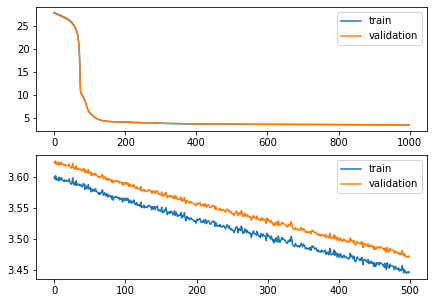

INFO:root:Train MAE: 3.4452, MAPE: 0.1303, MSE: 27.0251
INFO:root:Test MAE: 3.4706, MAPE: 0.1324, MSE: 26.9402
INFO:root:Fold 2/5


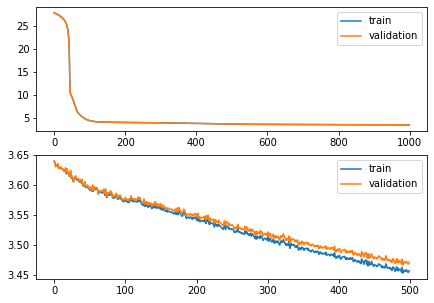

INFO:root:Train MAE: 3.4571, MAPE: 0.1308, MSE: 27.0588
INFO:root:Test MAE: 3.4711, MAPE: 0.1310, MSE: 27.3853
INFO:root:Fold 3/5


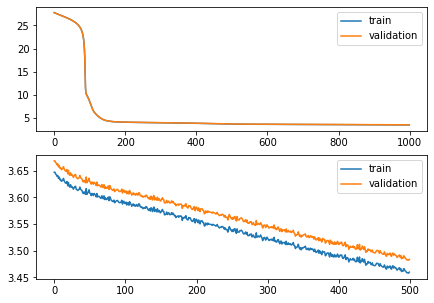

INFO:root:Train MAE: 3.4600, MAPE: 0.1307, MSE: 27.2085
INFO:root:Test MAE: 3.4839, MAPE: 0.1320, MSE: 27.2874
INFO:root:Fold 4/5


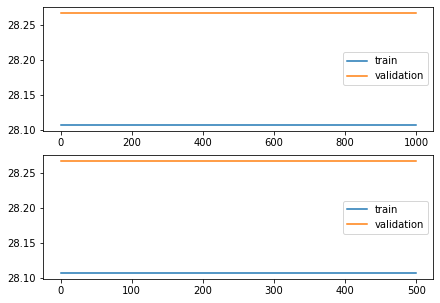

INFO:root:Train MAE: 28.1069, MAPE: 1.0000, MSE: 983.7089
INFO:root:Test MAE: 28.2675, MAPE: 1.0000, MSE: 995.0411
INFO:root:Fold 5/5


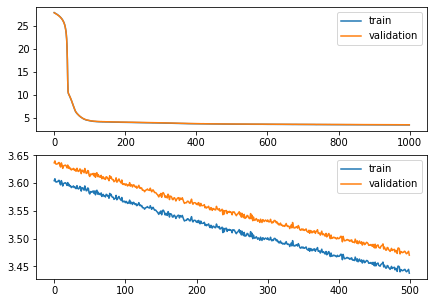

INFO:root:Train MAE: 3.4377, MAPE: 0.1307, MSE: 26.7349
INFO:root:Test MAE: 3.4702, MAPE: 0.1312, MSE: 27.1104
INFO:root:
Best model from fold 5
INFO:root:Best model mae: 3.4702, mape: 0.1312 mse: 27.1104

INFO:root:Average mae: 8.4327, mape: 0.3053, mse: 220.7529
INFO:root:Std mae: 9.9174, mape: 0.3473, mse: 387.1441

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in usage (87225 records): MAE: 3.4208, MAPE: 0.1332, MSE: 26.8731
INFO:root:Metrics for 1 cells in usage (5335 records): MAE: 3.8155, MAPE: 0.0889, MSE: 25.7796
INFO:root:No data for 2 cells in usage
INFO:root:Metrics for 3 cells in usage (40 records): MAE: 4.1407, MAPE: 0.0708, MSE: 27.4294


In [9]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout=0.25):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            self.layers.append(nn.ReLU())
            if i == 0:
                self.layers.append(nn.Dropout(dropout*0.8))

        self.layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.layers.append(nn.ReLU())

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
    

# define model and other parameters
input_size = _train_df.shape[1] - 1
hidden_sizes = [101, 41, 24, 7]
epochs = 1000
batch_size = 512
learning_rate = 0.00002
momentum = 0.9
verbose = False
dropout = 0.4

# define model
torch.manual_seed(42)

# define loss function and optimizer
criterion = nn.L1Loss()


def model_getter():
    return MultiLayerPerceptron(input_size, hidden_sizes, dropout=dropout)

def model_trainer(model, X, y, *args, **kwargs):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    X_train = torch.tensor(X.values, dtype=torch.float)
    y_train = torch.tensor(y.values, dtype=torch.float)

    X_validation = torch.tensor(kwargs["X_test"].values, dtype=torch.float)
    y_validation = torch.tensor(kwargs["y_test"].values, dtype=torch.float)

    train_losses = []
    validation_losses = []


    for epoch in range(epochs):
        model.train()
        # batch training
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            # forward pass
            optimizer.zero_grad()
            outputs = model.forward(batch_x)
            loss = criterion(outputs, batch_y.reshape(-1, 1))

            # backward pass
            loss.backward()
            optimizer.step()
            
        model.eval()

        with torch.no_grad():
            # calculate loss
            train_loss = criterion(model.forward(X_train), y_train.reshape(-1, 1))
            validation_loss = criterion(
                model.forward(X_validation), y_validation.reshape(-1, 1)
            )

            train_losses.append(train_loss.item())
            validation_losses.append(validation_loss.item())

            if verbose and epoch % 5 == 0:
                print(
                    "epoch {}, train loss {}, validation loss {}".format(
                        epoch, train_loss, validation_loss
                    )
                )

    # plot loss
    plt.rcParams["figure.figsize"] = (7, 5)

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label="train")
    plt.plot(validation_losses, label="validation")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_losses[epochs // 2:], label="train")
    plt.plot(validation_losses[epochs // 2:], label="validation")
    plt.legend()

    plt.show()


def model_predictor(model, X):
    X = torch.tensor(X.values, dtype=torch.float)
    model.eval()
    with torch.no_grad():
        return model.forward(X).numpy().reshape(-1)
    

model_eval = ModelEvalWrapper(
    model_getter,
    name="Basic MLP",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

model_eval.train_and_eval(_train_df)

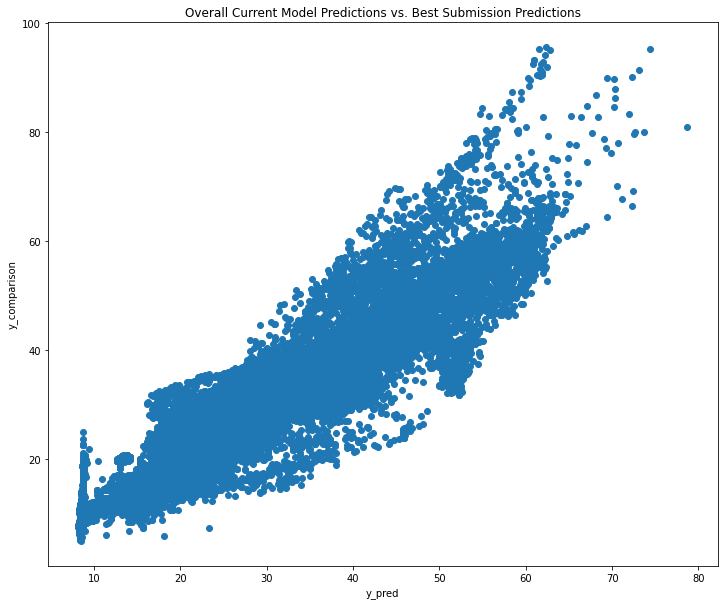

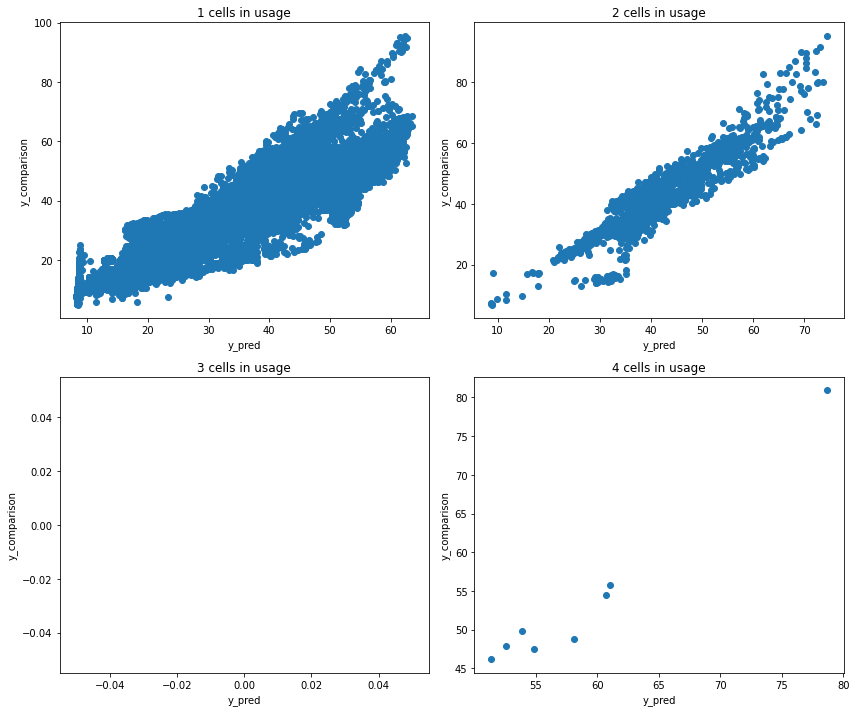

In [11]:
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df, best_submission['Energy'])

INFO:root:Fold 1/5


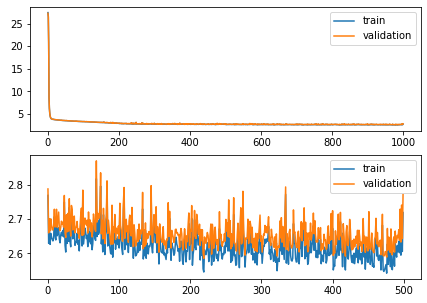

INFO:root:Train MAE: 2.7189, MAPE: 0.1049, MSE: 16.6146
INFO:root:Test MAE: 2.7711, MAPE: 0.1071, MSE: 15.4595
INFO:root:Fold 2/5


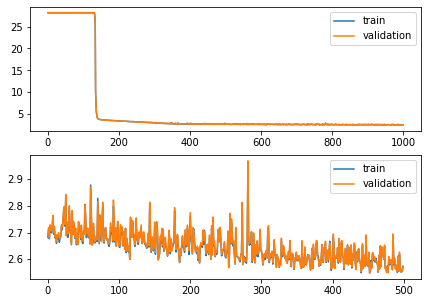

INFO:root:Train MAE: 2.5739, MAPE: 0.0941, MSE: 16.4673
INFO:root:Test MAE: 2.5721, MAPE: 0.0934, MSE: 14.5275
INFO:root:Fold 3/5


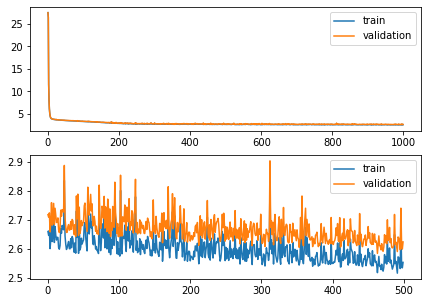

INFO:root:Train MAE: 2.5539, MAPE: 0.0912, MSE: 14.6650
INFO:root:Test MAE: 2.6247, MAPE: 0.0939, MSE: 33.4833
INFO:root:Fold 4/5


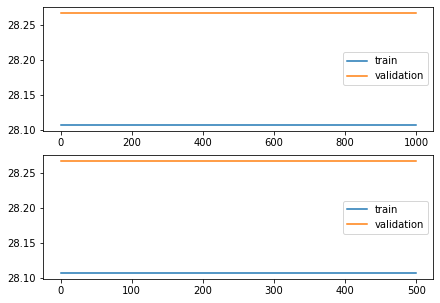

INFO:root:Train MAE: 28.1069, MAPE: 1.0000, MSE: 983.7089
INFO:root:Test MAE: 28.2675, MAPE: 1.0000, MSE: 995.0411
INFO:root:Fold 5/5


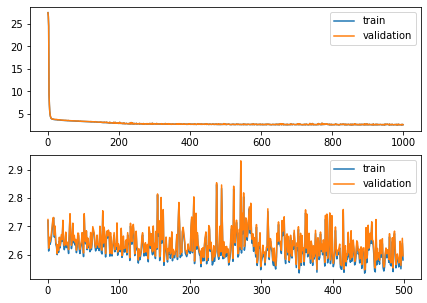

INFO:root:Train MAE: 2.5821, MAPE: 0.0936, MSE: 16.2463
INFO:root:Test MAE: 2.5967, MAPE: 0.0938, MSE: 14.7828
INFO:root:
Best model from fold 2
INFO:root:Best model mae: 2.5721, mape: 0.0934 mse: 14.5275

INFO:root:Average mae: 7.7664, mape: 0.2776, mse: 214.6588
INFO:root:Std mae: 10.2507, mape: 0.3612, mse: 390.2575

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in usage (87225 records): MAE: 2.5390, MAPE: 0.0951, MSE: 15.9678
INFO:root:Metrics for 1 cells in usage (5335 records): MAE: 3.1210, MAPE: 0.0731, MSE: 17.8185
INFO:root:No data for 2 cells in usage
INFO:root:Metrics for 3 cells in usage (40 records): MAE: 3.7661, MAPE: 0.0637, MSE: 22.7264


In [12]:
# define model and other parameters
input_size = _train_df.shape[1] - 1
hidden_sizes = [72, 72, 24]
epochs = 1000
batch_size = 256
learning_rate = 0.00015
momentum = 0.9
verbose = False
dropout = 0.6

# define model
torch.manual_seed(42)

# define loss function and optimizer
criterion = nn.L1Loss()


def model_getter():
    return MultiLayerPerceptron(input_size, hidden_sizes)

def model_trainer(model, X, y, *args, **kwargs):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    X_train = torch.tensor(X.values, dtype=torch.float)
    y_train = torch.tensor(y.values, dtype=torch.float)

    X_validation = torch.tensor(kwargs["X_test"].values, dtype=torch.float)
    y_validation = torch.tensor(kwargs["y_test"].values, dtype=torch.float)

    train_losses = []
    validation_losses = []


    for epoch in range(epochs):
        model.train()
        # batch training
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            # forward pass
            optimizer.zero_grad()
            outputs = model.forward(batch_x)
            loss = criterion(outputs, batch_y.reshape(-1, 1))

            # backward pass
            loss.backward()
            optimizer.step()
            
        model.eval()

        with torch.no_grad():
            # calculate loss
            train_loss = criterion(model.forward(X_train), y_train.reshape(-1, 1))
            validation_loss = criterion(
                model.forward(X_validation), y_validation.reshape(-1, 1)
            )

            train_losses.append(train_loss.item())
            validation_losses.append(validation_loss.item())

            if verbose and epoch % 5 == 0:
                print(
                    "epoch {}, train loss {}, validation loss {}".format(
                        epoch, train_loss, validation_loss
                    )
                )

    # plot loss
    plt.rcParams["figure.figsize"] = (7, 5)

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label="train")
    plt.plot(validation_losses, label="validation")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_losses[epochs // 2:], label="train")
    plt.plot(validation_losses[epochs // 2:], label="validation")
    plt.legend()

    plt.show()


def model_predictor(model, X):
    X = torch.tensor(X.values, dtype=torch.float)
    model.eval()
    with torch.no_grad():
        return model.forward(X).numpy().reshape(-1)
    

model_eval = ModelEvalWrapper(
    model_getter,
    name="Basic MLP",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

model_eval.train_and_eval(_train_df)

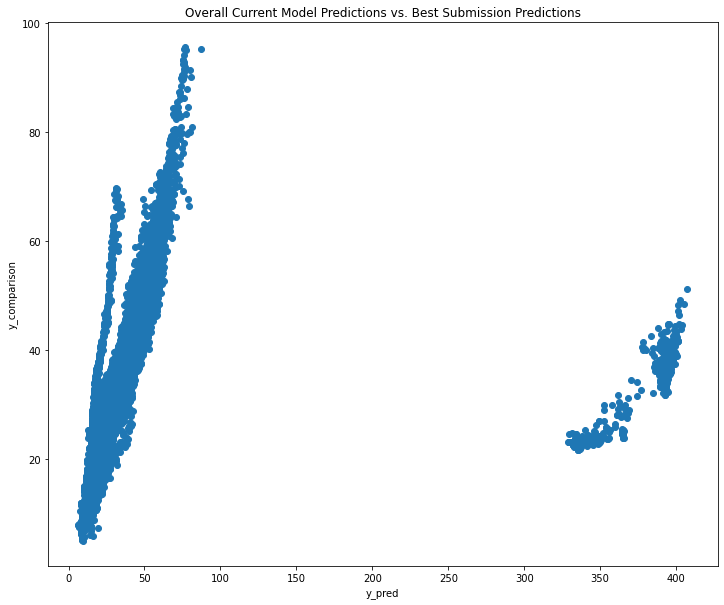

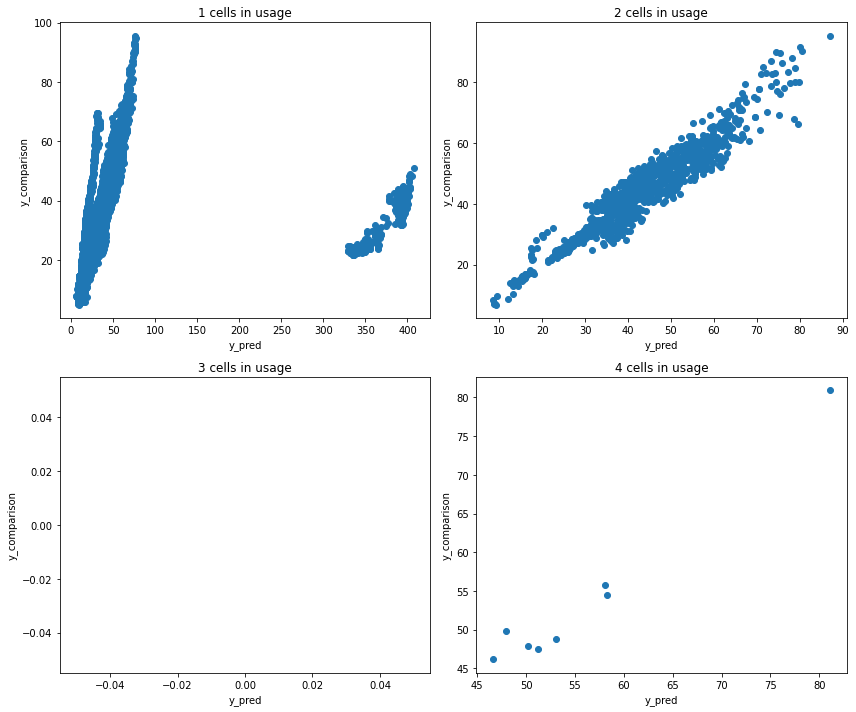

In [10]:
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df, best_submission['Energy'])